In [1]:
import numpy as np
import sciope

from sciope.utilities.priors.uniform_prior import UniformPrior
from sciope.utilities.summarystats.identity import Identity
from sciope.utilities.distancefunctions.euclidean import EuclideanDistance
from sciope.utilities.perturbationkernels.multivariate_normal import MultivariateNormalKernel
from sciope.utilities.epsilonselectors.relative_epsilon_selector import RelativeEpsilonSelector
from sciope.utilities.epsilonselectors.absolute_epsilon_selector import AbsoluteEpsilonSelector

from sciope.inference.abc_inference import ABC
from sciope.inference.smc_abc import SMCABC
from sciope.inference.rep_smc_abc import ReplenishmentSMCABC

import matplotlib.pyplot as plt

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [2]:
def simulator(param, n=100):
    """
    Simulate a given parameter combination.

    Parameters
    ----------
    param : vector or 1D array
        Parameters to simulate (\theta).
    n : integer
        Time series length
    """
    m = len(param)
    g = np.random.normal(0, 1, n)
    gy = np.random.normal(0, 0.3, n)
    y = np.zeros(n)
    x = np.zeros(n)
    for t in range(0, n):
        x[t] += g[t]
        for p in range(0, np.minimum(t, m)):
            x[t] += g[t - 1 - p] * param[p]
        y[t] = x[t] + gy[t]
    
    return np.reshape(y, (1,1,100))

# Data

In [2]:
#target_ts = np.load('target_ts.npy')
obs_data = np.load('target_ts.npy')

In [3]:
obs_data.shape

(1, 100, 1)

In [4]:
obs_data = np.reshape(obs_data, (1, 1, 100))

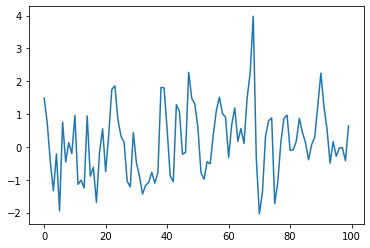

In [6]:
plt.plot(obs_data[0].T)

# Prior Distributions

true = [0.6, 0.2]

In [7]:
parameter_names = ['k1', 'k2']

lower_bounds = [-2, -1]
upper_bounds = [2, 1]

prior = UniformPrior(np.array(lower_bounds), np.array(upper_bounds))

# Summary Statistics and Distance Function

### Statistics and Euclidean Distance

In [61]:
distance_func = EuclideanDistance()

In [35]:
from sciope.utilities.summarystats import auto_tsfresh

default_fc_params = {
                     'variance':None,
                     'autocorrelation':
                         [{'lag':1},
                          {'lag':2}]}

summaries = auto_tsfresh.SummariesTSFRESH(features=default_fc_params)

In [61]:
#test
summaries.compute(simulator([0.1,0.2]))

array([[ 1.06345798, -0.10766169,  0.18812816]])

# Inference

### Using ABC-SMC


In [ ]:
from sciope.inference.smc_abc import SMCABC

In [53]:
# Several runs to evaluate robustness, takes a long time to run. 
# If one like to just test the code change tot_runs

results = []
tot_runs = 10

for i in range(tot_runs):
    print(f'statring run{i}')

    max_rounds = 6
    eps_selector = RelativeEpsilonSelector(20, max_rounds)

    smcabc = SMCABC(obs_data, # Observed Dataset
              simulator, # Simulator method
              prior, # Prior
              summaries_function=summaries.compute
              )

    %time smc_abc_results = smcabc.infer(num_samples = 3000, batch_size = 1, chunk_size=1, eps_selector=eps_selector)

    results.append(smc_abc_results)

statring run0
Determining initial population using 20
Starting epsilon = 0.7253871151081972
Starting epsilon = 0.34903585949235433
Starting epsilon = 0.18546637673857977
Starting epsilon = 0.1052172322919937
Starting epsilon = 0.06049133273847076
CPU times: user 39min 10s, sys: 2min 45s, total: 41min 56s
Wall time: 39min 49s
statring run1
Determining initial population using 20
Starting epsilon = 0.7100442510861815
Starting epsilon = 0.3411904875278523
Starting epsilon = 0.18435838376866998
Starting epsilon = 0.10160641010440132
Starting epsilon = 0.05827375287116587
CPU times: user 43min 20s, sys: 3min 2s, total: 46min 22s
Wall time: 44min 2s
statring run2
Determining initial population using 20
Starting epsilon = 0.7420393197071374
Starting epsilon = 0.35237083019429616
Starting epsilon = 0.1844659262070908
Starting epsilon = 0.1023284205480118
Starting epsilon = 0.05875373853814394
CPU times: user 41min 4s, sys: 2min 51s, total: 43min 55s
Wall time: 41min 42s
statring run3
Determini

In [54]:
#Get posterior samples and the number of candidate trials in each round
smc_posterios = []
smc_trail_count = []

for i in results:
    run = []
    trial = []
    for j in i:
        run.append(j['accepted_samples'])
        trial.append(j['trial_count'])
    smc_posterios.append(run)
    smc_trail_count.append(trial)

In [55]:
smc_posteriors = np.array(smc_posterios)
smc_trail_count = np.array(smc_trail_count)

In [57]:
#Save data
ID = 'data'
    try:
        os.mkdir(ID)
    except FileExistsError:
        print(f'{ID} folder already exists, continue...')

np.save(f'{ID}/smcabc_trails_10gen', smc_trail_count)
np.save(f'{ID}/smcabc_post_10gen', smc_posteriors)